In [ ]:
from os.path import dirname, abspath,join
import sys
import numpy as np
import pandas as pd
import json
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

root_path = dirname(abspath("./"))
import sys
sys.path.append(root_path)
from prochain_transformer.predict import *

In [2]:
def plot_predictions(
    sample_id: int, var_index: int, target_array: np.ndarray, 
    output_array: np.ndarray, title_map: dict=None, 
    save: bool=False):
    
    vars = np.unique(target_array[:,:,var_index])
    vars = vars[~np.isnan(vars)]
    num_vars = len(vars)
    
    fig = plt.figure(figsize=(6*num_vars, 4))
    gs = gridspec.GridSpec(1, num_vars)

    for i,var in enumerate(vars):
        var_mask = target_array[sample_id, :, var_index] == var
        x = target_array[sample_id, :, x_index][var_mask]
        y_out = output_array[sample_id][var_mask]
        y_trg = target_array[sample_id, :, val_index][var_mask]
        ax = fig.add_subplot(gs[i])
        ax.plot(x, y_out, label="prediction")
        ax.plot(x, y_trg, label="target")
        ax.grid(True)
        ax.set_ylabel("Normalized Value")
        ax.set_xlabel("Position")
        
        title = var.map(title_map) if title_map is not None else var
        
        ax.set_title(f"Variable: {title}")
        ax.legend()
    
    if save:
        fig.savefig("prediction.png", dpi=300, bbox_inches='tight')
    
    plt.show()



def plot_attention(sample_id: int, cross_att_array: np.ndarray, input_array: np.ndarray, save: bool=False):
    cross_att = cross_att_array[sample_id]
    N, M = cross_att.shape
    input_miss_bool = np.isnan(input_array[sample_id,:,val_index].squeeze())
    input_miss = input_miss_bool[np.newaxis,:].astype(int)

    fig = plt.figure(figsize=(6, 5))
    gs = gridspec.GridSpec(2, 1, height_ratios=[10, 1], hspace=0.5)

    # Main heatmap axis
    ax0 = fig.add_subplot(gs[0])
    divider0 = make_axes_locatable(ax0)
    cax0 = divider0.append_axes("right", size="5%", pad=0.1)
    im0 = ax0.imshow(cross_att, cmap='viridis', aspect='auto', origin='upper')
    fig.colorbar(im0, cax=cax0, label='Value')
    ax0.set_xticks([])
    ax0.set_ylabel("Rows")
    ax0.set_title("Heatmap with Boolean Mask")

    # Boolean mask axis
    ax1 = fig.add_subplot(gs[1], sharex=ax0)
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.1)
    im1 = ax1.imshow(input_miss, cmap='Greys', aspect='auto', origin='upper', vmin=0, vmax=1)
    fig.colorbar(im1, cax=cax1, ticks=[0, 1], label='Missing')
    cax1.set_yticklabels(['False', 'True'])

    ax1.set_yticks([])
    ax1.set_xlabel("Columns")
    num_labels = min(M, 10)  # Ensure we don't exceed 10 labels
    step = M // num_labels if M > 10 else 1  # Calculate step for the labels

    ax1.set_xticks(np.arange(0, M, step))  # Set ticks at evenly spaced intervals
    ax1.set_xticklabels(np.arange(0, M, step))  # Show corresponding labels

    if save:
        fig.savefig("prediction.png", dpi=300, bbox_inches='tight')
    
    plt.show()
    


def get_group_score(sample_id: int, group_index: int, val_index: int, cross_att_array: np.ndarray, input_array: np.ndarray):
    
    cross_att = cross_att_array[sample_id]
    cumul_scores = np.mean(cross_att, axis=0)
    
    group_array = np.unique(input_array[sample_id,:,group_index])
    group_array = group_array[~np.isnan(group_array)]
    count_dict = {}
    for group in group_array:

        mask = np.logical_and(
            input_array[sample_id, :, group_index] == group, 
            ~np.isnan(input_array[sample_id, :, val_index]))
        count_dict[group] = np.mean(cumul_scores[mask])
    
    return pd.DataFrame.from_dict(count_dict, orient='index').reset_index()



def make_plots(
    sample_id: int, var_index: int, target_array: np.ndarray, 
    output_array: np.ndarray, cross_att_array: np.ndarray, title_map: dict=None, 
    save: bool=False):
    
    plot_predictions(sample_id, var_index, target_array, output_array, title_map, save)
    plot_attention(sample_id, cross_att_array, input_array, save)

## Load Experiment

In [3]:
datadir_path = r"../data/input"
config_path = r"../experiments/training/test_opt4/config.yaml"
checkpoint_path = r"../experiments/training/test_opt4/sweeps/sweep_emb_lr/sweep_emb_lr_0.001/k_0/checkpoints/epoch=999-train_loss=0.00.ckpt"

config = OmegaConf.load(config_path)
input_array, output_array, target_array, cross_att_array = predict_test_from_ckpt(config, datadir_path, checkpoint_path, cluster=False)

Global seed set to 42


c:\ProgramData\anaconda3\envs\prochain_transformer\Lib\site-packages\pytorch_lightning\utilities\migration\utils.py:51: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.5.0.post0, which is newer than your current Lightning version: v2.0.3
  rank_zero_warn(


Test dataset selected (default).
Predicting...


100%|██████████| 1/1 [00:17<00:00, 17.30s/it]


In [4]:
dataset_name = config["data"]["dataset"][3:]

In [5]:
# files
dataset_name = config["data"]["dataset"][3:]
builds_dir = "../../process_pipeline/data/builds"
var_vocab_filepath = join(builds_dir, dataset_name, "output/variables_vocabulary.json")
pos_vocab_filepath = join(builds_dir, dataset_name, "output/position_vocabulary.json")
rating_filepath = join(builds_dir, dataset_name, "control/steps_selected.xlsx")

with open(var_vocab_filepath, 'r', encoding='utf-8') as file:
    inv_var_dict = json.load(file)
    
with open(pos_vocab_filepath, 'r', encoding='utf-8') as file:
    inv_pos_dict = json.load(file)

df_rating = pd.read_excel(rating_filepath)

# maps
var_map = {v: k[:3] for k, v in inv_var_dict.items()}
pos_map = {v: int(float(k)) for k, v in inv_pos_dict.items()}
rate_map = df_rating.set_index("Step")["Bewertung "].to_dict()
process_map = df_rating.set_index("Step")["Process"].to_dict()

In [6]:
# define data indices
var_index = 2
x_index = 3
val_index = 4

# get variables
vars = np.unique(target_array[:,:,var_index])
vars = vars[~np.isnan(vars)]
num_vars = len(vars)

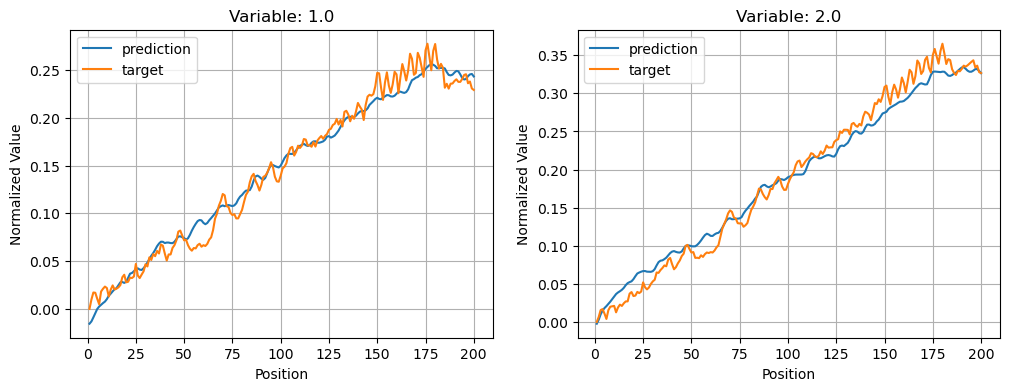

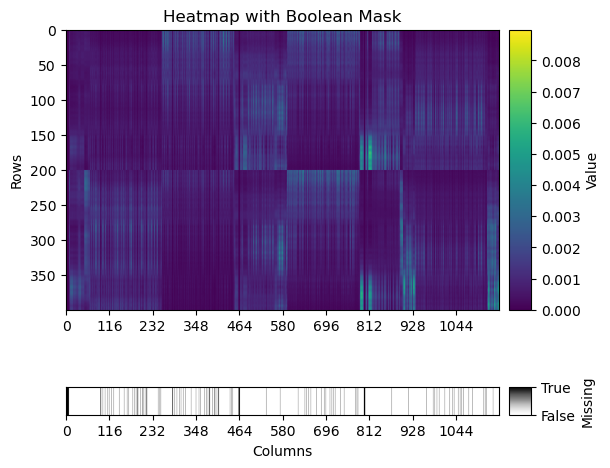

In [11]:
sample_id = 5

make_plots(sample_id, var_index, target_array, output_array, cross_att_array)

In [14]:
group_index = x_index
df = get_group_score(sample_id, group_index,val_index, cross_att_array, input_array)  
df["PaPos"] = df["index"].map(pos_map)
df["rating"] = df["PaPos"].map(rate_map)
df["process"] = df["PaPos"].map(process_map)
df

c:\ProgramData\anaconda3\envs\prochain_transformer\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\ProgramData\anaconda3\envs\prochain_transformer\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


,index,0,PaPos,rating,process
0,1.0,NaN,40,3,Laser
1,2.0,0.000896,60,3,Plasma
2,4.0,0.000870,80,1,Galvanic
3,5.0,0.000787,90,3,Galvanic
4,8.0,0.001058,200,2,Multibond
5,13.0,0.001330,290,1,Microetch
6,14.0,0.000965,300,3,Galvanic
7,17.0,0.001072,410,2,Multibond
8,20.0,0.001367,470,3,Laser
9,22.0,0.001141,500,2,Microetch


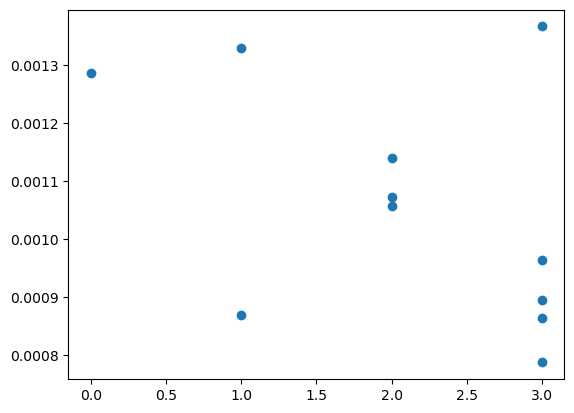

In [13]:
plt.scatter(df["rating"],df[0])